# GANs For Art

## Importing the modules

In [ ]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
%matplotlib inline

## Preparing the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
artists = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/artwork/artists.csv")

for i in artists['name']:
    print(i,end=" | ")

Amedeo Modigliani | Vasiliy Kandinskiy | Diego Rivera | Claude Monet | Rene Magritte | Salvador Dali | Edouard Manet | Andrei Rublev | Vincent van Gogh | Gustav Klimt | Hieronymus Bosch | Kazimir Malevich | Mikhail Vrubel | Pablo Picasso | Peter Paul Rubens | Pierre-Auguste Renoir | Francisco Goya | Frida Kahlo | El Greco | Albrecht Dürer | Alfred Sisley | Pieter Bruegel | Marc Chagall | Giotto di Bondone | Sandro Botticelli | Caravaggio | Leonardo da Vinci | Diego Velazquez | Henri Matisse | Jan van Eyck | Edgar Degas | Rembrandt | Titian | Henri de Toulouse-Lautrec | Gustave Courbet | Camille Pissarro | William Turner | Edvard Munch | Paul Cezanne | Eugene Delacroix | Henri Rousseau | Georges Seurat | Paul Klee | Piet Mondrian | Joan Miro | Andy Warhol | Paul Gauguin | Raphael | Michelangelo | Jackson Pollock | 

In [ ]:
batch_size = 128
pic_size = 128

image_size = (pic_size,pic_size)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
transform_ds = transforms.Compose([transforms.Resize(image_size),
#                                    transforms.RandomCrop(32, padding=2),
#                                    transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

train_ds = torchvision.datasets.ImageFolder(root="/content/drive/MyDrive/Colab Notebooks/artwork/resized",
                                     transform=transform_ds)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
print(len(train_ds))

8693


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([3, 128, 128])


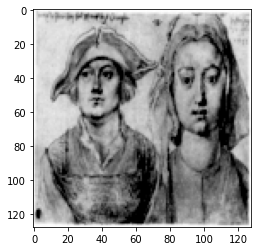

In [ ]:
images,_ = train_ds[382]
print(images.size())
plt.imshow(images.permute(1,2,0))

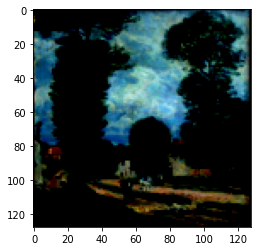

In [ ]:
images,_ = train_ds[872]
plt.imshow(images.permute(1,2,0))

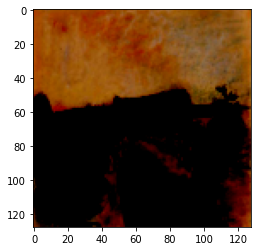

In [ ]:
images,_ = train_ds[1912]
plt.imshow(images.permute(1,2,0))

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

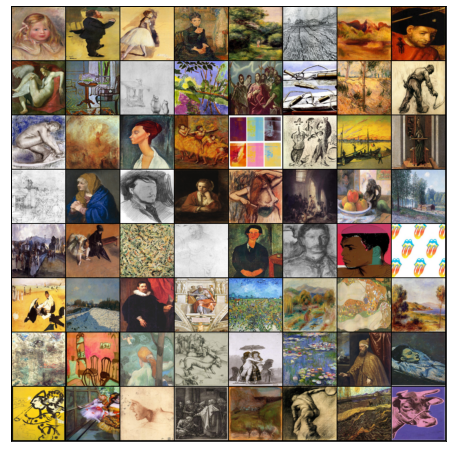

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, pic_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(pic_size),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(pic_size, pic_size*2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(pic_size*2),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(pic_size*2, pic_size*4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(pic_size*4),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(pic_size*4, pic_size*6, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(pic_size*6),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(pic_size*6, pic_size*8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(pic_size*8),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(pic_size*8, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 512

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, pic_size*8, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(pic_size*8),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(pic_size*8, pic_size*6, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(pic_size*6),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(pic_size*6, pic_size*4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(pic_size*4),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(pic_size*4, pic_size*2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(pic_size*2),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(pic_size*2, pic_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(pic_size),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(pic_size, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [ ]:
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/artwork/generated/checkpoints/G.ckpt'):
    print("Loading GEN model from checkpoint")
    generator.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/artwork/generated/checkpoints/G.ckpt'))
    generator.train()
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/artwork/generated/checkpoints/D.ckpt'):
    print("Loading DISC model from checkpoint")
    discriminator.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/artwork/generated/checkpoints/D.ckpt'))
    discriminator.train()


Loading GEN model from checkpoint
Loading DISC model from checkpoint


## Defining the model

torch.Size([128, 3, 128, 128])


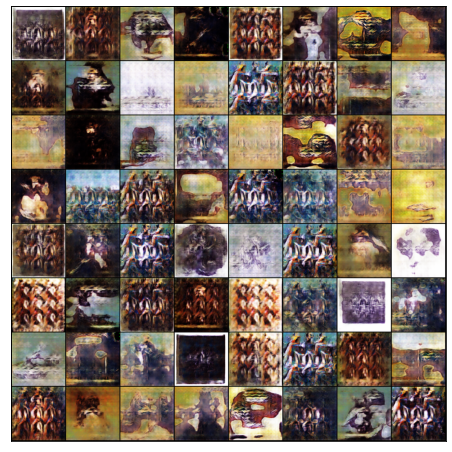

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images) ##Check here
    real_targets = torch.ones(real_images.size(0), 1, device=device)

    #print("HEREERE", real_preds.size(), real_targets.size())

    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    #print("HEREERE", fake_images.size())

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    #print("at descriminator")
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
lr = 0.001
epochs = 150

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)

    if index % 10 == 0:
      image_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/artwork/generated", str(index))
      os.mkdir(image_dir)
      
      for j, image in enumerate(fake_images):
        fname = f"final-{j}-{fake_fname}"
        save_image(denorm(image), os.path.join(image_dir, fname))

    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(pic_size, latent_size, 1, 1, device=device)

In [ ]:
#save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    if os.path.exists('/content/drive/MyDrive/Colab Notebooks/artwork/generated/checkpoints/D-opt.ckpt'):
      opt_d.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/artwork/generated/checkpoints/D-opt.ckpt'))
    if os.path.exists('/content/drive/MyDrive/Colab Notebooks/artwork/generated/checkpoints/G-opt.ckpt'):
      opt_g.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/artwork/generated/checkpoints/G-opt.ckpt'))

    counter_file = os.path.join("/content/drive/MyDrive/Colab Notebooks/artwork/generated/counter.txt")

    if not os.path.exists(counter_file):
      with open(counter_file, 'w') as f:
        f.write("0")

    while True:
        with open(counter_file, 'r') as f:
          epoch = int(f.read()) + 1
 
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            #print('here1')
            #print(real_images.size())
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            #print('here2')
            # Train generator
            loss_g = train_generator(opt_g)
            #print('here3')
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch, 'unlimited', loss_g, loss_d, real_score, fake_score))

        # Save checkpoints
        torch.save(generator.state_dict(), '/content/drive/MyDrive/Colab Notebooks/artwork/generated/checkpoints/G.ckpt')
        torch.save(discriminator.state_dict(), '/content/drive/MyDrive/Colab Notebooks/artwork/generated/checkpoints/D.ckpt')
        torch.save(opt_g.state_dict(), '/content/drive/MyDrive/Colab Notebooks/artwork/generated/checkpoints/G-opt.ckpt')
        torch.save(opt_d.state_dict(), '/content/drive/MyDrive/Colab Notebooks/artwork/generated/checkpoints/D-opt.ckpt')
    
        # Save generated images
        save_samples(epoch, fixed_latent, show=False)

        with open(counter_file, 'w') as f:
          f.write(str(epoch))
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 68 kB 7.5 MB/s 


In [ ]:
history = fit(lr)

  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [393/unlimited], loss_g: 8.8999, loss_d: 0.0904, real_score: 0.9998, fake_score: 0.0693
Saving generated-images-0393.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [394/unlimited], loss_g: 9.3565, loss_d: 0.0214, real_score: 0.9917, fake_score: 0.0123
Saving generated-images-0394.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [395/unlimited], loss_g: 10.2499, loss_d: 0.0541, real_score: 0.9955, fake_score: 0.0313
Saving generated-images-0395.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [396/unlimited], loss_g: 13.9074, loss_d: 0.0027, real_score: 0.9998, fake_score: 0.0025
Saving generated-images-0396.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [397/unlimited], loss_g: 16.3041, loss_d: 0.2984, real_score: 0.8250, fake_score: 0.0000
Saving generated-images-0397.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [398/unlimited], loss_g: 8.7513, loss_d: 0.0057, real_score: 0.9985, fake_score: 0.0040
Saving generated-images-0398.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [399/unlimited], loss_g: 10.4079, loss_d: 0.0578, real_score: 0.9981, fake_score: 0.0427
Saving generated-images-0399.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [400/unlimited], loss_g: 8.8040, loss_d: 0.0505, real_score: 0.9828, fake_score: 0.0174
Saving generated-images-0400.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [401/unlimited], loss_g: 8.3191, loss_d: 0.0144, real_score: 0.9947, fake_score: 0.0082
Saving generated-images-0401.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [402/unlimited], loss_g: 9.7389, loss_d: 0.0127, real_score: 1.0000, fake_score: 0.0118
Saving generated-images-0402.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [403/unlimited], loss_g: 10.1121, loss_d: 0.0163, real_score: 0.9971, fake_score: 0.0130
Saving generated-images-0403.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [404/unlimited], loss_g: 10.4990, loss_d: 0.0878, real_score: 0.9902, fake_score: 0.0605
Saving generated-images-0404.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [405/unlimited], loss_g: 11.7632, loss_d: 0.0135, real_score: 0.9885, fake_score: 0.0015
Saving generated-images-0405.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [406/unlimited], loss_g: 9.9404, loss_d: 0.0603, real_score: 0.9983, fake_score: 0.0472
Saving generated-images-0406.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [407/unlimited], loss_g: 7.9173, loss_d: 0.0626, real_score: 1.0000, fake_score: 0.0510
Saving generated-images-0407.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [408/unlimited], loss_g: 15.1711, loss_d: 0.2563, real_score: 0.9975, fake_score: 0.1650
Saving generated-images-0408.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [409/unlimited], loss_g: 12.9604, loss_d: 2.9827, real_score: 0.3105, fake_score: 0.0000
Saving generated-images-0409.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [410/unlimited], loss_g: 14.3326, loss_d: 0.0320, real_score: 0.9738, fake_score: 0.0002
Saving generated-images-0410.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [411/unlimited], loss_g: 7.9433, loss_d: 0.0330, real_score: 0.9999, fake_score: 0.0284
Saving generated-images-0411.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [412/unlimited], loss_g: 10.0479, loss_d: 0.0481, real_score: 0.9929, fake_score: 0.0140
Saving generated-images-0412.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [413/unlimited], loss_g: 8.8885, loss_d: 0.0035, real_score: 0.9976, fake_score: 0.0011
Saving generated-images-0413.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [414/unlimited], loss_g: 10.5517, loss_d: 0.0414, real_score: 0.9857, fake_score: 0.0140
Saving generated-images-0414.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [415/unlimited], loss_g: 9.3225, loss_d: 0.0088, real_score: 0.9993, fake_score: 0.0073
Saving generated-images-0415.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [416/unlimited], loss_g: 8.2290, loss_d: 0.0467, real_score: 0.9999, fake_score: 0.0345
Saving generated-images-0416.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [417/unlimited], loss_g: 9.4344, loss_d: 0.0087, real_score: 0.9988, fake_score: 0.0072
Saving generated-images-0417.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [418/unlimited], loss_g: 11.1432, loss_d: 0.2985, real_score: 0.8460, fake_score: 0.0013
Saving generated-images-0418.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [419/unlimited], loss_g: 12.0101, loss_d: 0.0500, real_score: 0.9668, fake_score: 0.0046
Saving generated-images-0419.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [420/unlimited], loss_g: 12.3708, loss_d: 0.1094, real_score: 0.9472, fake_score: 0.0421
Saving generated-images-0420.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [421/unlimited], loss_g: 10.7175, loss_d: 0.1111, real_score: 0.9349, fake_score: 0.0005
Saving generated-images-0421.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [422/unlimited], loss_g: 8.4057, loss_d: 0.0567, real_score: 0.9999, fake_score: 0.0476
Saving generated-images-0422.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [423/unlimited], loss_g: 7.4026, loss_d: 0.0262, real_score: 0.9868, fake_score: 0.0114
Saving generated-images-0423.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [424/unlimited], loss_g: 6.6607, loss_d: 0.0428, real_score: 0.9979, fake_score: 0.0368
Saving generated-images-0424.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [425/unlimited], loss_g: 7.2327, loss_d: 0.0301, real_score: 0.9970, fake_score: 0.0237
Saving generated-images-0425.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [426/unlimited], loss_g: 7.7440, loss_d: 0.0765, real_score: 0.9791, fake_score: 0.0440
Saving generated-images-0426.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [427/unlimited], loss_g: 33.9268, loss_d: 2.1303, real_score: 1.0000, fake_score: 0.6507
Saving generated-images-0427.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [428/unlimited], loss_g: 9.1969, loss_d: 0.0107, real_score: 0.9975, fake_score: 0.0077
Saving generated-images-0428.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [429/unlimited], loss_g: 9.3494, loss_d: 0.0407, real_score: 0.9806, fake_score: 0.0166
Saving generated-images-0429.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [430/unlimited], loss_g: 8.9903, loss_d: 0.0008, real_score: 0.9995, fake_score: 0.0003
Saving generated-images-0430.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [431/unlimited], loss_g: 6.5299, loss_d: 0.1189, real_score: 0.9115, fake_score: 0.0040
Saving generated-images-0431.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [432/unlimited], loss_g: 19.8573, loss_d: 0.2245, real_score: 0.9961, fake_score: 0.1582
Saving generated-images-0432.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [433/unlimited], loss_g: 9.9563, loss_d: 0.0049, real_score: 0.9982, fake_score: 0.0030
Saving generated-images-0433.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [434/unlimited], loss_g: 7.7292, loss_d: 0.0247, real_score: 0.9869, fake_score: 0.0098
Saving generated-images-0434.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [435/unlimited], loss_g: 8.4299, loss_d: 0.1073, real_score: 0.9223, fake_score: 0.0019
Saving generated-images-0435.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [436/unlimited], loss_g: 6.7495, loss_d: 0.6890, real_score: 0.6693, fake_score: 0.0000
Saving generated-images-0436.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [437/unlimited], loss_g: 10.9137, loss_d: 0.0148, real_score: 0.9999, fake_score: 0.0109
Saving generated-images-0437.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [438/unlimited], loss_g: 7.5716, loss_d: 1.5525, real_score: 0.4414, fake_score: 0.0001
Saving generated-images-0438.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [439/unlimited], loss_g: 8.0719, loss_d: 0.0224, real_score: 0.9911, fake_score: 0.0128
Saving generated-images-0439.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [440/unlimited], loss_g: 10.7685, loss_d: 0.0099, real_score: 0.9912, fake_score: 0.0004
Saving generated-images-0440.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [441/unlimited], loss_g: 12.3890, loss_d: 0.0048, real_score: 0.9961, fake_score: 0.0009
Saving generated-images-0441.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [442/unlimited], loss_g: 10.9964, loss_d: 0.1566, real_score: 0.9965, fake_score: 0.0520
Saving generated-images-0442.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [443/unlimited], loss_g: 4.5553, loss_d: 0.1223, real_score: 0.9347, fake_score: 0.0045
Saving generated-images-0443.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [444/unlimited], loss_g: 10.1002, loss_d: 0.0330, real_score: 0.9803, fake_score: 0.0106
Saving generated-images-0444.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [445/unlimited], loss_g: 8.4589, loss_d: 0.0846, real_score: 0.9889, fake_score: 0.0376
Saving generated-images-0445.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [446/unlimited], loss_g: 7.6976, loss_d: 0.0995, real_score: 0.9996, fake_score: 0.0788
Saving generated-images-0446.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [447/unlimited], loss_g: 9.5681, loss_d: 0.0313, real_score: 0.9792, fake_score: 0.0073
Saving generated-images-0447.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [448/unlimited], loss_g: 12.1532, loss_d: 0.0024, real_score: 0.9988, fake_score: 0.0011
Saving generated-images-0448.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [449/unlimited], loss_g: 13.2517, loss_d: 0.0120, real_score: 0.9998, fake_score: 0.0113
Saving generated-images-0449.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [450/unlimited], loss_g: 10.1961, loss_d: 0.0331, real_score: 0.9800, fake_score: 0.0094
Saving generated-images-0450.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [451/unlimited], loss_g: 8.9718, loss_d: 0.0161, real_score: 0.9957, fake_score: 0.0112
Saving generated-images-0451.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [452/unlimited], loss_g: 10.3787, loss_d: 0.0040, real_score: 0.9991, fake_score: 0.0029
Saving generated-images-0452.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [453/unlimited], loss_g: 5.7383, loss_d: 0.0410, real_score: 0.9997, fake_score: 0.0371
Saving generated-images-0453.png


  0%|          | 0/68 [00:00<?, ?it/s]

In [ ]:
from IPython.display import Image 

In [ ]:
Image('./generated/generated-images-0013.png')

In [ ]:
Image('./generated/generated-images-0037.png')

In [ ]:
Image('./generated/generated-images-0072.png')

In [ ]:
Image('./generated/generated-images-0103.png')

In [ ]:
Image('./generated/generated-images-0138.png')

In [ ]:
Image('./generated/generated-images-0147.png')

In [ ]:
Image('./generated/generated-images-0150.png')

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints 
#torch.save(generator.state_dict(), 'G.ckpt')
#torch.save(discriminator.state_dict(), 'D.ckpt')

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()